In [ ]:
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cufflinks as cf
from scipy import stats

import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)  

# Some styling
sns.set_style("whitegrid")
plt.style.use("fivethirtyeight")

import plotly.io as pio
pio.renderers.default = 'colab'
pio.templates.default = 'ggplot2'
%matplotlib inline

# Disable warnings 
import warnings
warnings.filterwarnings('ignore')

### Import Dev Data

In [ ]:
raw_data_link = 'https://raw.githubusercontent.com/elvanselvano/purwadhika-final-project/main/dataset/dev_data.csv'
df = pd.read_csv(raw_data_link) # using dev set

In [ ]:
df.head()

,index,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,PRICE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,SOURCE,CMPLX_NUM,LIVING_GBA,FULLADDRESS,CITY,STATE,ZIPCODE,NATIONALGRID,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT,SALEYEAR
0,2,3,1,Hot Water Rad,Y,2.0,9,5,1910.0,2009.0,1984,3.0,2016-06-21,2100000.0,Q,3,2522.0,1,3 Story,Row Inside,Very Good,Very Good,Common Brick,Built Up,Hardwood,2.0,4,24,1680,2018-07-22 18:01:43,Residential,NaN,NaN,1744 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23074 09289,38.914684,-77.040678,Old City 2,040 D Old City 2,4201.0,004201 2006,Ward 2,152,-77.040429,38.914881,NW,2016.0
1,18,3,1,Hot Water Rad,Y,2.0,10,4,1908.0,2006.0,1967,2.0,2016-08-18,NaN,U,6,1542.0,1,2 Story,Row Inside,Above Average,Good,Common Brick,Metal- Sms,Hardwood,2.0,1,24,1424,2018-07-22 18:01:43,Residential,NaN,NaN,1731 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23132 09324,38.915016,-77.040020,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,152,-77.040429,38.914881,NW,2016.0
2,20,3,1,Hot Water Rad,Y,1.0,14,5,1880.0,2009.0,1987,3.0,2016-01-12,33232.0,U,3,3465.0,1,3 Story,Semi-Detached,Very Good,Very Good,Common Brick,Built Up,Hardwood,1.0,3,13,2090,2018-07-22 18:01:43,Residential,NaN,NaN,1441 Q STREET NW,WASHINGTON,DC,20009.0,18S UJ 23665 08908,38.911370,-77.033774,Old City 2,040 E Old City 2,5201.0,005201 4003,Ward 2,208,-77.033366,38.911716,NW,2016.0
3,31,3,0,Forced Air,Y,2.0,9,3,1900.0,2004.0,1963,3.0,2016-06-10,NaN,U,4,2592.0,1,3 Story,Row Inside,Good Quality,Good,Common Brick,Built Up,Hardwood/Carp,2.0,1,24,1853,2018-07-22 18:01:43,Residential,NaN,NaN,1448 CORCORAN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23652 08947,38.911719,-77.033933,Old City 2,040 E Old City 2,5201.0,005201 4003,Ward 2,208,-77.033366,38.911716,NW,2016.0
4,34,3,1,Forced Air,Y,2.0,10,3,1900.0,2008.0,1969,3.0,2018-04-12,NaN,U,3,4208.0,1,3 Story,Row Inside,Good Quality,Good,Common Brick,Built Up,Hardwood,2.0,3,24,1853,2018-07-22 18:01:43,Residential,NaN,NaN,1438 CORCORAN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23683 08945,38.911707,-77.033570,Old City 2,040 E Old City 2,5201.0,005201 4003,Ward 2,208,-77.033366,38.911716,NW,2018.0


### 1. CASTING

In [ ]:
#casting data types
def casting(df):
  df['NUM_UNITS'] = df['NUM_UNITS'].astype(pd.Int64Dtype())
  df['AYB'] = df['AYB'].astype(pd.Int64Dtype())
  df['LANDAREA'] = df['LANDAREA'].astype(float)
  df['KITCHENS'] = df['KITCHENS'].astype(pd.Int64Dtype())
  df['USECODE'] = df['USECODE'].astype(pd.Int64Dtype()).astype('category')
  df['ZIPCODE'] = df['ZIPCODE'].astype(pd.Int64Dtype()).astype('category')
  df['CMPLX_NUM'] = df['CMPLX_NUM'].astype(pd.Int64Dtype())
  df['CENSUS_TRACT'] = df['CMPLX_NUM'].astype(pd.Int64Dtype())
  df['SALEDATE'] = pd.to_datetime(df['SALEDATE'])
  return df

In [ ]:
df1 = casting(df)

In [ ]:
def saleyear(df):
  df['SALEYEAR'] = df['SALEDATE'].dt.year
  return df

In [ ]:
df2 = saleyear(df1)

### 2. QUALIFIED FEATURES 

The `QUALIFIED` feature is internally-used indicator to reflect if a sale is representative of market value according to the office's internal criteria. Since the `U` means it does not reflect the market value, we will drop the `U` value and `QUALIFIED` feature since it only contains 1 value of `Q`.

In [ ]:
def drop_qualified(df):
  df = df[df['QUALIFIED']=='Q']
  df = df.drop('QUALIFIED', axis=1)
  
  return df

In [ ]:
df[(df['QUALIFIED']=='U') & (df['PRICE']>0) & (df['SALEYEAR']>2010) & (df['ROOMS']<=6) & (df['GBA']>1204) & (df['LANDAREA']>1425) & (df['AYB']>1914) & (df['EYB']>1964) & (df['PRICE']>500000) & (df['WARD']=='Ward 5')]

,index,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,PRICE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,SOURCE,CMPLX_NUM,LIVING_GBA,FULLADDRESS,CITY,STATE,ZIPCODE,NATIONALGRID,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT,SALEYEAR
11117,76793,3,0,Forced Air,Y,1,6,4,1940,2010.0,1967,2.0,2016-12-15,699999.0,U,5,1769.0,1,2 Story,Single,Above Average,Good,Brick/Siding,Comp Shingle,Hardwood,2,2,12,2813.0,2018-07-22 18:01:43,Residential,<NA>,NaN,2621 QUEENS CHAPEL ROAD NE,WASHINGTON,DC,20018,18S UJ 28743 10204,38.924053,-76.975563,Woodridge,056 C Woodridge,<NA>,011100 3006,Ward 5,4213,-76.974893,38.924060,NE,2016
11300,78056,3,1,Warm Cool,Y,1,6,4,1925,2017.0,1969,1.0,2017-03-01,839900.0,U,4,2072.0,1,1 Story,Single,Good Quality,Good,Vinyl Siding,Comp Shingle,Hardwood,1,0,12,3750.0,2018-07-22 18:01:43,Residential,<NA>,NaN,3619 SOUTH DAKOTA AVENUE NE,WASHINGTON,DC,20018,18S UJ 28833 11393,38.934777,-76.974822,Woodridge,056 A Woodridge,<NA>,009400 4018,Ward 5,4225,-76.974573,38.934784,NE,2017
11410,78757,1,1,Hot Water Rad,N,1,6,3,1935,2004.0,1967,2.5,2016-10-14,725000.0,U,6,1664.0,1,2.5 Story Unfin,Single,Above Average,Good,Common Brick,Comp Shingle,Hardwood/Carp,1,2,12,4310.0,2018-07-22 18:01:43,Residential,<NA>,NaN,1715 HAMLIN STREET NE,WASHINGTON,DC,20018,18S UJ 28355 10645,38.927946,-76.980136,Brookland,007 D Brookland,<NA>,009301 3012,Ward 5,4134,-76.980474,38.927802,NE,2016


In [ ]:
df3 = drop_qualified(df2)

In [ ]:
print('Before removing unqualified:', df2.shape)
print('After removing unqualified:', df3.shape)

Before removing unqualified: (26573, 50)
After removing unqualified: (16072, 49)


### 3. MISSING DATA

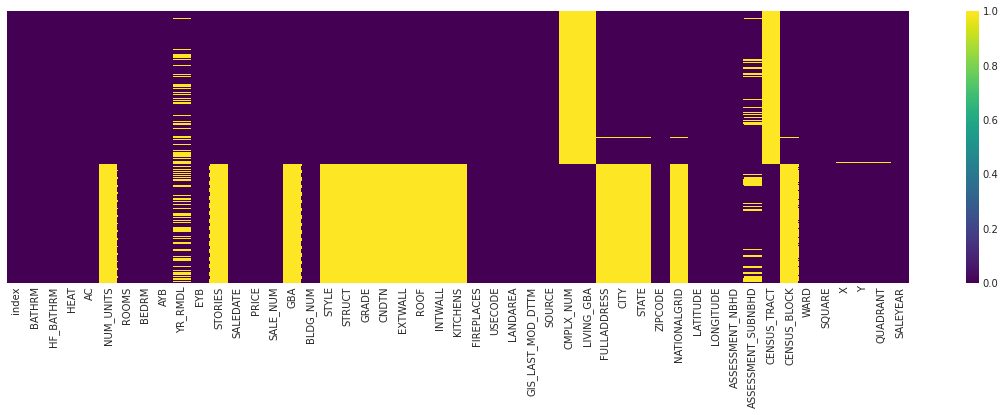

In [ ]:
fig, ax = plt.subplots(figsize=(18,5))
sns.heatmap(df3.isnull(), yticklabels=False, cmap='viridis')
plt.show()

Since the missing values seems to have a pattern, we might want to dig deeper into the source (`residential` & `condominium`)

In [ ]:
res = df3[df3['SOURCE']=='Residential']
con = df3[df3['SOURCE']=='Condominium']

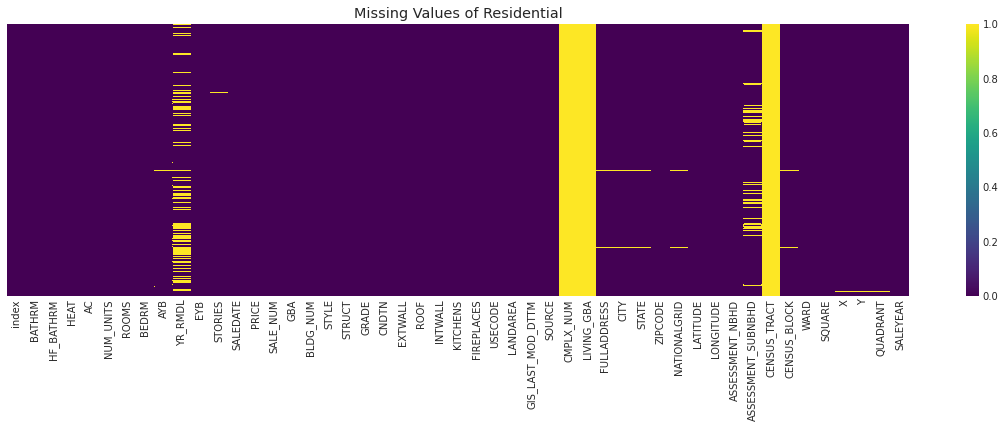

In [ ]:
fig, ax = plt.subplots(figsize=(18,5))
sns.heatmap(res.isnull(), yticklabels=False,cmap='viridis').set_title('Missing Values of Residential')
plt.show()

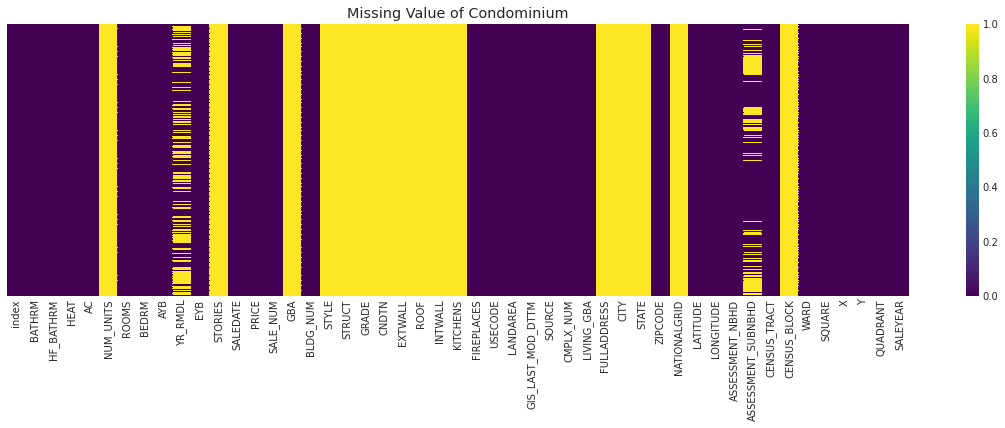

In [ ]:
fig, ax = plt.subplots(figsize=(18,5))
sns.heatmap(con.isnull(), yticklabels=False,cmap='viridis').set_title('Missing Value of Condominium')
plt.show()

Clearly, they both have several different features. We assume that the price predictor model of residential and condominium will be different. The condominium data seems to have more missing value than the residential. In this case, we decide to build the price predictor for **`residential`** property only.

In [ ]:
def residential(df):
  df = df[df['SOURCE']=='Residential']
  return df

In [ ]:
df4 = residential(df3)

In [ ]:
df4.shape

(9112, 49)

Dropping unused features :
- `CMPLX_NUM`, `LIVING_GBA`, `CENSUS_TRACT` : only available in condominium data
- `ASSESSMENT_SUBNBHD`, `FULLADDRESS`, `NATIONAL GRID`, and `CENSUS_BLOCK` : high cardinality
- `CITY`, `STATE` : single value (Washington, DC)
- `X`, `Y` : same value with `LONGITUDE` and `LATITUDE`
- `SALEDATE` : replaced with `SALEYEAR`

In [ ]:
def drop_unused_features(df):
    df = df.drop(['CMPLX_NUM','LIVING_GBA','CENSUS_TRACT','ASSESSMENT_SUBNBHD',
                   'FULLADDRESS','NATIONALGRID','CENSUS_BLOCK','CITY','STATE',
                   'X','Y','SALEDATE'],axis=1)
    return df

In [ ]:
df5 = drop_unused_features(df4)

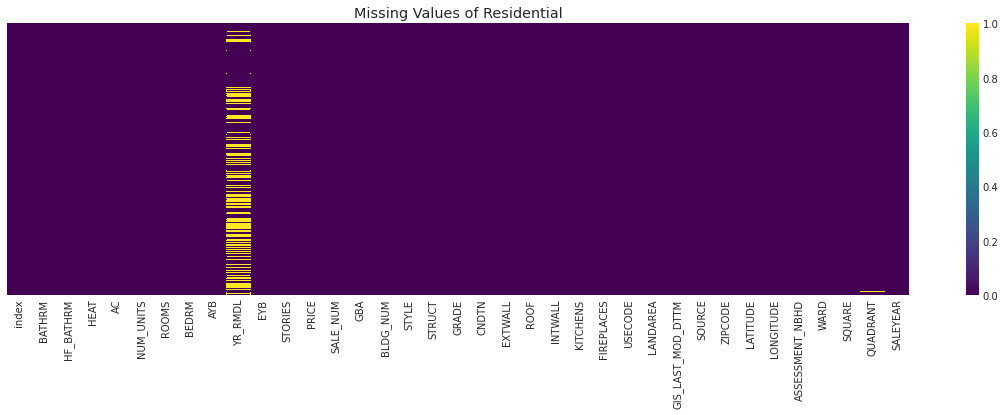

In [ ]:
fig, ax = plt.subplots(figsize=(18,5))
sns.heatmap(df5.isnull(), yticklabels=False,cmap='viridis').set_title('Missing Values of Residential')
plt.show()

The `YR_RMDL` features seems too important to drop. Intuitively, whether the properties have been remodeled or not will affect the price. We decide to do feature engineering by converting the `YR_RMDL` into `RMDL`, which is (`1`/`0`). `1` means the property has been remodeled and vice versa.

In [ ]:
#feature engineering YR_RMDL
def yr_rmdl(df):
    df['RMDL'] = np.where(df['YR_RMDL'].isna(),0,1)
    df = df.drop('YR_RMDL',axis=1)
    return df

In [ ]:
df6 = yr_rmdl(df5)

In [ ]:
df6.shape

(9112, 37)

In [ ]:
# drop remaining missing values (price)
def drop_all(df):
  df = df.dropna()
  return df

In [ ]:
df7 = drop_all(df6)

In [ ]:
df7.shape

(9067, 37)

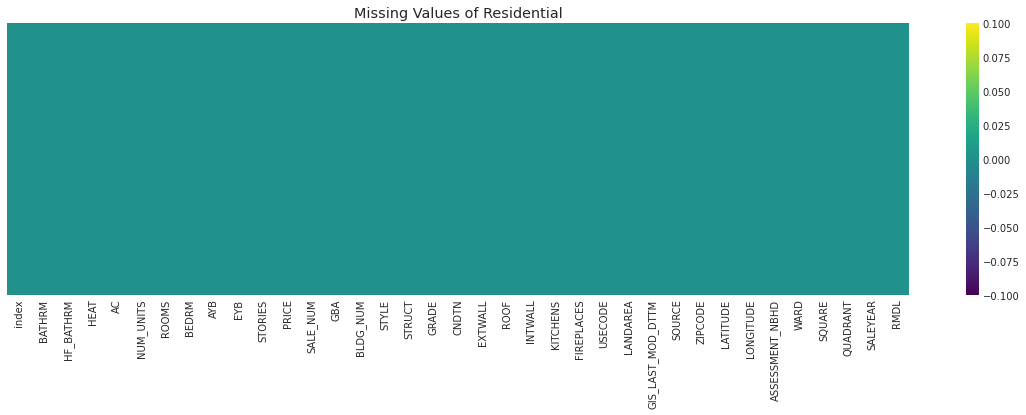

In [ ]:
fig, ax = plt.subplots(figsize=(18,5))
sns.heatmap(df7.isnull(), yticklabels=False,cmap='viridis').set_title('Missing Values of Residential')
plt.show()

### 4. UNRELATED COLUMNS

some features do not related to the properties (update version date and source data)

In [ ]:
def drop_unrelated_features(df):
    df = df.drop(['GIS_LAST_MOD_DTTM','SOURCE'],axis=1)
    return df

In [ ]:
df8 = drop_unrelated_features(df7)

In [ ]:
df8.shape

(9067, 35)

### 5. UNUSUAL VALUES

In [ ]:
df8['AC'].value_counts() #checking unusual values of AC (0)

Y    7424
N    1640
0       3
Name: AC, dtype: int64

Convert `AC` to `1` and `0` (values of `0` is considered as `N`)

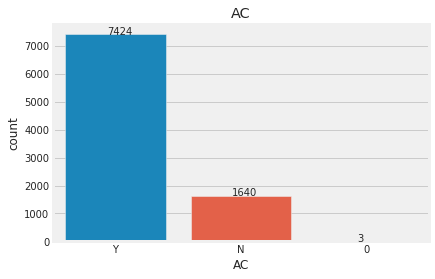

In [ ]:
ax = sns.countplot(df7["AC"], 
                   order = df7["AC"].value_counts().index)
plt.title('AC')

for p, label in zip(ax.patches, df7["AC"].value_counts().values):
    ax.annotate(label, (p.get_x()+0.33, p.get_height()+0.5))

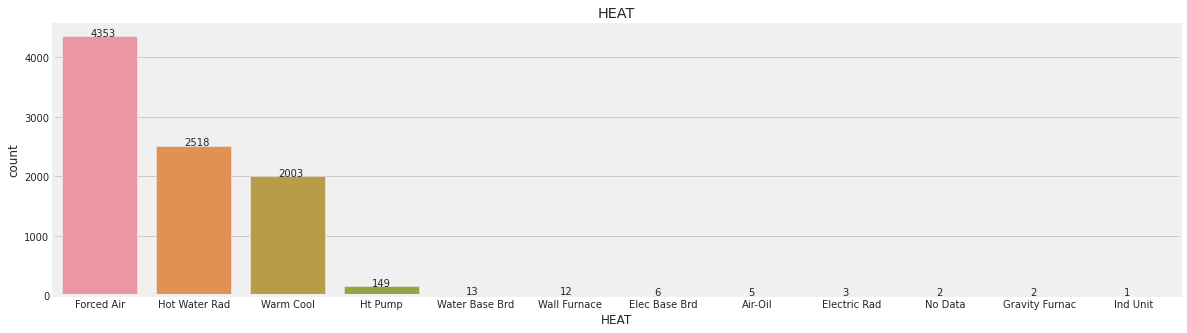

In [ ]:
plt.figure(figsize=(18,5))
ax = sns.countplot(df7["HEAT"], 
                   order = df7["HEAT"].value_counts().index)
plt.title('HEAT')

for p, label in zip(ax.patches, df7["HEAT"].value_counts().values):
    ax.annotate(label, (p.get_x()+0.3, p.get_height()+0.5))

In [ ]:
df8['HEAT'].value_counts() # checking unusual values of HEAT (No Data)

Forced Air        4353
Hot Water Rad     2518
Warm Cool         2003
Ht Pump            149
Water Base Brd      13
Wall Furnace        12
Elec Base Brd        6
Air-Oil              5
Electric Rad         3
No Data              2
Gravity Furnac       2
Ind Unit             1
Name: HEAT, dtype: int64

Since `No Data` of `HEAT` is considered small, we will drop the records containing it.

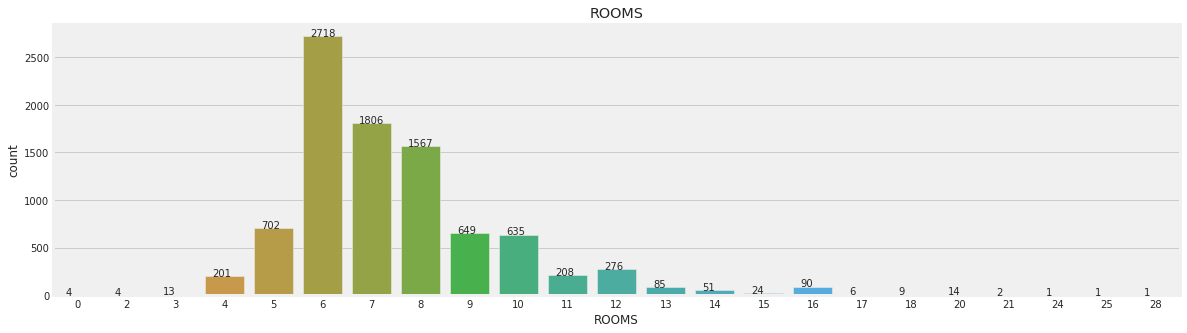

In [ ]:
plt.figure(figsize=(18,5))
ax = sns.countplot(df7["ROOMS"], 
                   order = df7["ROOMS"].value_counts().sort_index().index)
plt.title('ROOMS')

for p, label in zip(ax.patches, df7["ROOMS"].value_counts().sort_index().values):
    ax.annotate(label, (p.get_x()+0.15, p.get_height()+0.5))

In [ ]:
df8['ROOMS'].value_counts().sort_index() # checking unusual values of ROOMS (0)

0        4
2        4
3       13
4      201
5      702
6     2718
7     1806
8     1567
9      649
10     635
11     208
12     276
13      85
14      51
15      24
16      90
17       6
18       9
20      14
21       2
24       1
25       1
28       1
Name: ROOMS, dtype: int64

We will drop properties with `0` room which is highly unlikely 

In [ ]:
df8[df8['AYB'] > df8['SALEYEAR']].shape #checking unusual values of interaction between AYB & SALEYEAR

(6, 35)

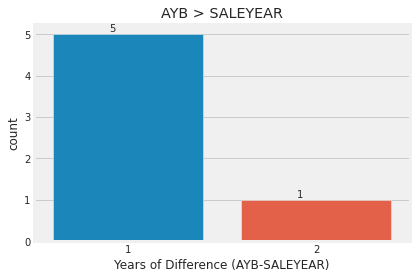

In [ ]:
diff_ayb_saleyear = df8[df8['AYB'] > df8['SALEYEAR']]
ax = sns.countplot(diff_ayb_saleyear['AYB'] - diff_ayb_saleyear['SALEYEAR'])
plt.title('AYB > SALEYEAR')
plt.xlabel('Years of Difference (AYB-SALEYEAR)')
for p, label in zip(ax.patches, (diff_ayb_saleyear['AYB'] - diff_ayb_saleyear['SALEYEAR']).value_counts().sort_index().values):
    ax.annotate(label, (p.get_x()+0.3, p.get_height()+0.05))
plt.show() 

We assume there is no sold properties before the properties has been built. Since these values is scarce, we will exclude the records

In [ ]:
df8[df8['AYB'] > df8['EYB']].shape #checking unusual values of interaction between AYB & EYB

(1, 35)

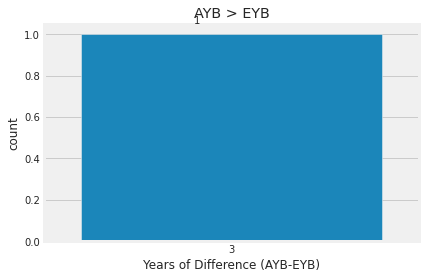

In [ ]:
diff_ayb_eyb = df8[df8['AYB'] > df8['EYB']]
ax = sns.countplot(diff_ayb_eyb['AYB'] - diff_ayb_eyb['EYB'])
plt.title('AYB > EYB')
plt.xlabel('Years of Difference (AYB-EYB)')
for p, label in zip(ax.patches, (diff_ayb_eyb['AYB'] - diff_ayb_eyb['EYB']).value_counts().sort_index().values):
    ax.annotate(label, (p.get_x()+0.3, p.get_height()+0.05))
plt.show() 

Based on the Author explanation of the dataset, the `EYB` should be more recent than the `AYB`. We found 3 unusual values, which we will drop

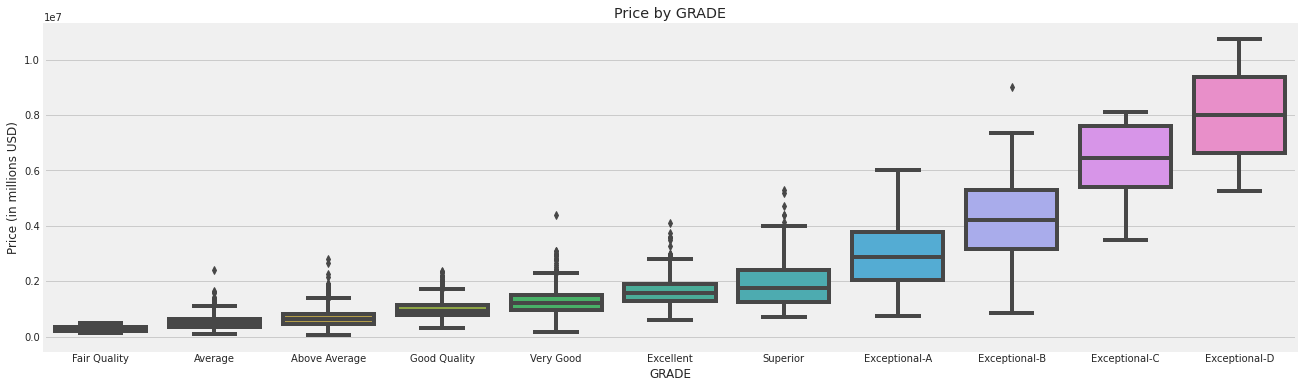

In [ ]:
plt.figure(figsize=(20,6))
df_no_na = df8[['GRADE','PRICE']].copy().dropna()
table = df_no_na.groupby(['GRADE'],as_index=False)['PRICE'].median().sort_values(by='PRICE',ascending=True)
sns.boxplot(x='GRADE',y='PRICE',data=df_no_na,order=table['GRADE'].to_list())
plt.ylabel('Price (in millions USD)')
plt.title('Price by GRADE')
plt.show()

In [ ]:
df_no_na['GRADE'].value_counts()

Average          3086
Above Average    2688
Good Quality     1814
Very Good         769
Excellent         303
Superior          286
Exceptional-A      80
Exceptional-B      24
Fair Quality        9
Exceptional-C       6
Exceptional-D       2
Name: GRADE, dtype: int64

In [ ]:
# plt.figure(figsize=(20,6))
# order = ['Low Quality', 'Fair Quality', 'Average', 'Above Average','Good Quality','Very Good']
# ax = sns.countplot(df_no_na['GRADE'],order=table['GRADE'].to_list())
# plt.title('Number of Properties by GRADE')
# for p, label in zip(ax.patches, [1,33,11145,10815,7966,3552,1275,1015,319,117,26,22]):
#     ax.annotate(label, (p.get_x()+0.3, p.get_height()+0.7))
# plt.show() 

In [ ]:
df8.groupby('GRADE')['PRICE'].median().sort_values() #check price gradient of GRADE

GRADE
Fair Quality      283000.0
Average           493250.0
Above Average     650000.0
Good Quality      928000.0
Very Good        1220000.0
Excellent        1573225.0
Superior         1750000.0
Exceptional-A    2880000.0
Exceptional-B    4201250.0
Exceptional-C    6450000.0
Exceptional-D    8000000.0
Name: PRICE, dtype: float64

In [ ]:
df8['GRADE'].value_counts() #check number of records for each GRADE category

Average          3086
Above Average    2688
Good Quality     1814
Very Good         769
Excellent         303
Superior          286
Exceptional-A      80
Exceptional-B      24
Fair Quality        9
Exceptional-C       6
Exceptional-D       2
Name: GRADE, dtype: int64

Based on the price gradient for each `GRADE`, we can consider the `exceptional` grade as luxurious property. Since the price gap are quite high and the records are rare, we decide to limit our prediction model by excluding those in `exceptional` grade and fair quality.

In [ ]:
#drop unusual values
def drop_unusual(df):
  df['AC'] = np.where(df['AC']=='Y',1,0) #convert to 1 0 
  df = df[df['HEAT']!='No Data'] #delete no data
  df = df[df['ROOMS']!=0] #exclude property with 0 rooms
  df = df[df['AYB']<= df['SALEYEAR']] #exclude values where AYB > SALEYEAR
  df = df[df['AYB']<= df['EYB']] #exclude values where AYB > EYB
  df = df[~df['GRADE'].isin(['Exceptional-D','Exceptional-C','Exceptional-B',
                             'Exceptional-A', 'Fair Quality'])] #exclude exceptional GRADE
  df = df[(df['PRICE'] < 1200000) & (df['PRICE'] > 250000)] # 10% quantile and 90% quantile

  return df

In [ ]:
df9 = drop_unusual(df8)

In [ ]:
df9.shape

(7231, 35)

### 6. SIMILAR VALUES

- `STORIES` has similar values with `STYLE`. We keep `STYLE` since `STORIES` has many outliers due to mistyping.

In [ ]:
df9[['STORIES','STYLE']].value_counts()

STORIES  STYLE          
2.00     2 Story            5875
3.00     3 Story             397
2.50     2.5 Story Fin       243
1.00     1 Story             214
1.50     1.5 Story Fin       111
1.75     2 Story              61
2.25     2.5 Story Fin        60
         2 Story              49
4.00     4 Story              31
3.00     2 Story              28
2.50     2.5 Story Unfin      17
2.25     2.5 Story Unfin      17
2.50     2 Story              16
1.25     1.5 Story Fin        12
1.00     Split Foyer           9
1.25     1 Story               8
1.00     2 Story               7
2.00     3 Story               7
         Split Level           6
1.75     1.5 Story Fin         6
2.00     1 Story               5
2.75     3 Story               4
1.50     1.5 Story Unfin       4
1.00     Split Level           4
1.25     1.5 Story Unfin       3
2.00     2.5 Story Fin         3
         1.5 Story Fin         3
         2.5 Story Unfin       3
         1.5 Story Unfin       2
5.00     2 Story  

In [ ]:
def drop_similar_features(df):
    df = df.drop(['STORIES'], axis=1)
    
    return df

In [ ]:
df10 = drop_similar_features(df9)

In [ ]:
df10.shape

(7231, 34)

### 7. CORRELATION

CATEGORICAL (CRAMERS V)

In [ ]:
from itertools import combinations
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorical-categorical association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

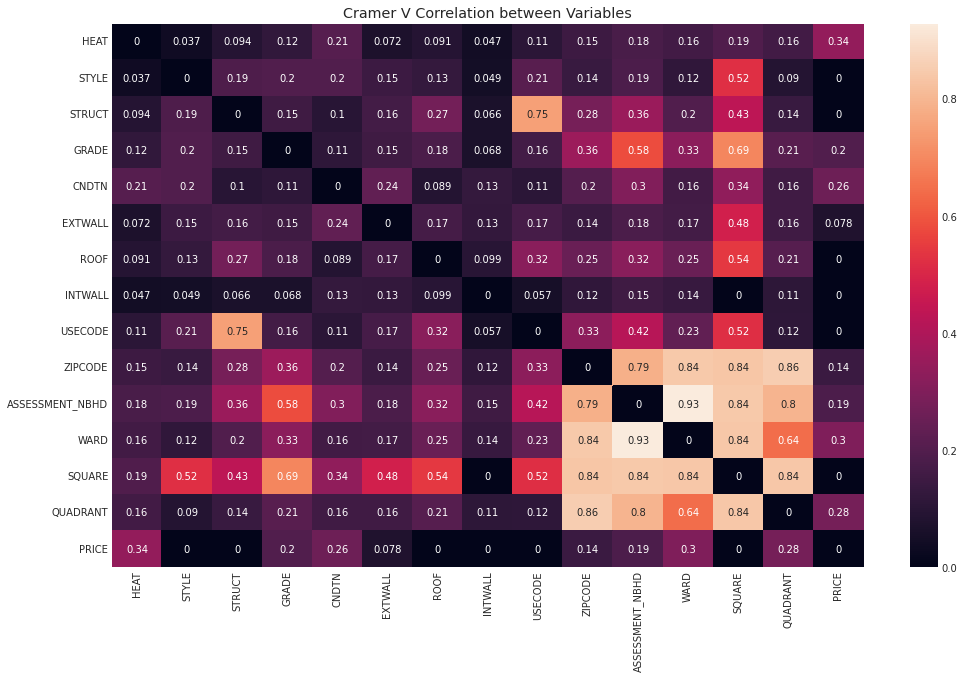

In [ ]:
cols = ['HEAT','STYLE','STRUCT', 'GRADE', 'CNDTN', 'EXTWALL','ROOF', 'INTWALL','USECODE','ZIPCODE','ASSESSMENT_NBHD','WARD','SQUARE','QUADRANT','PRICE']
# fitur kategorikal yang diambil yang sekiranya dapat di korelasikan dengan 'Price', kategori geographical yang diambil hanya yang mempunyai distinct data yg kecil
corrM = np.zeros((len(cols),len(cols)))
# there's probably a nice pandas way to do this
for col1, col2 in combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df10[col1], df10[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]

corr = pd.DataFrame(corrM, index=cols, columns=cols)
fig, ax = plt.subplots(figsize=(15, 10))
ax = sns.heatmap(corr, annot=True, ax=ax); ax.set_title("Cramer V Correlation between Variables");

The location features seems to have interaction with each other. Based on multiple trial on the model, we decide to take only `WARD`, since it is one of the top feature importance according to our model.

We also want to drop `LONGLAT` since it is already represented by the `WARD`.

In [ ]:
df10.columns

Index(['index', 'BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'NUM_UNITS', 'ROOMS',
       'BEDRM', 'AYB', 'EYB', 'PRICE', 'SALE_NUM', 'GBA', 'BLDG_NUM', 'STYLE',
       'STRUCT', 'GRADE', 'CNDTN', 'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS',
       'FIREPLACES', 'USECODE', 'LANDAREA', 'ZIPCODE', 'LATITUDE', 'LONGITUDE',
       'ASSESSMENT_NBHD', 'WARD', 'SQUARE', 'QUADRANT', 'SALEYEAR', 'RMDL'],
      dtype='object')

In [ ]:
def drop_location_features(df):
    df = df.drop(['ZIPCODE','ASSESSMENT_NBHD','SQUARE','QUADRANT',
                  'LATITUDE','LONGITUDE'], axis=1)
    
    return df

In [ ]:
df11 = drop_location_features(df10)

In [ ]:
df11.shape

(7231, 28)

NUMERICAL

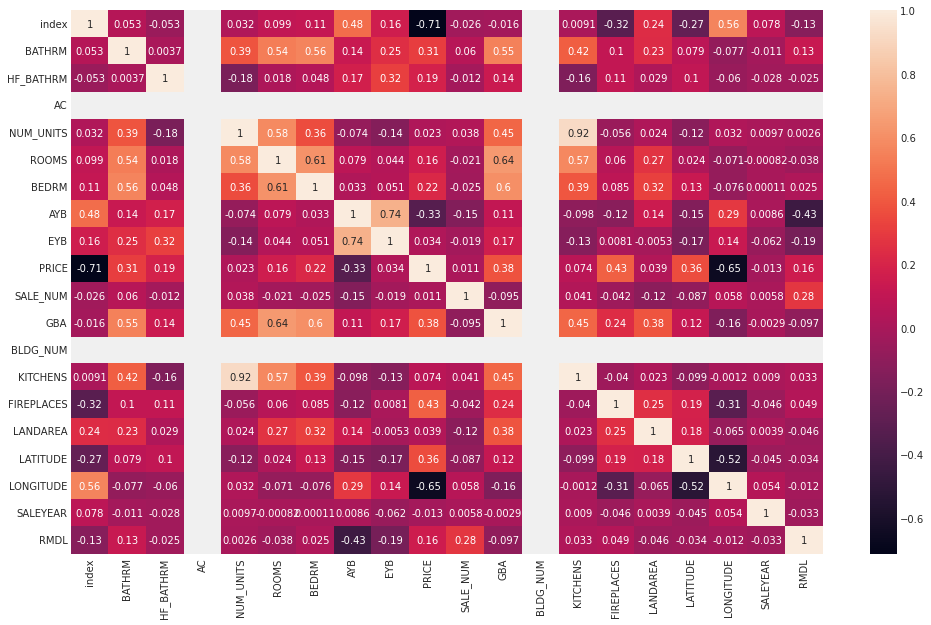

In [ ]:
plt.figure(figsize=(15,10))
sns.heatmap(df10.corr(), annot=True)
plt.show()

Some multicollinearity occurs between :
  - `NUM_UNITS` vs `KITCHENS`

Weak correlation :
 - `BLDG_NUM`

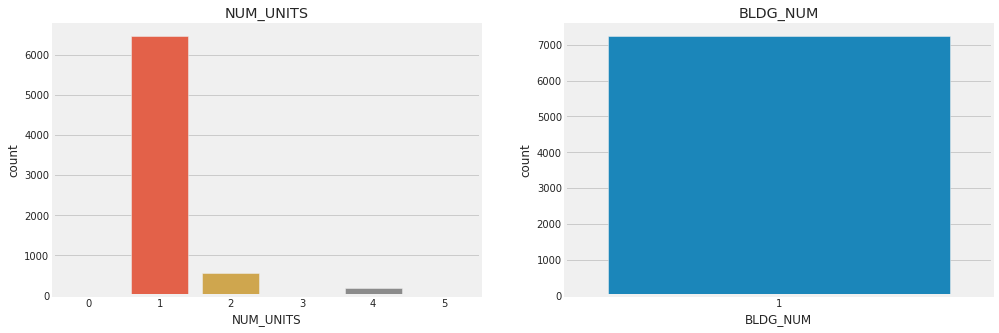

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(15,5))
sns.countplot(df11['NUM_UNITS'], ax=ax[0]).set_title('NUM_UNITS')
sns.countplot(df11['BLDG_NUM'], ax=ax[1]).set_title('BLDG_NUM')
plt.show()

Since both of the feature has imbalanced values and is not considered important based on our model trial, we decide to drop both features

In [ ]:
def drop_correlation(df):
    df = df.drop(['NUM_UNITS','BLDG_NUM'], axis=1)
    
    return df

In [ ]:
df12 = drop_correlation(df11)

In [ ]:
df12.columns

Index(['index', 'BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'ROOMS', 'BEDRM', 'AYB',
       'EYB', 'PRICE', 'SALE_NUM', 'GBA', 'STYLE', 'STRUCT', 'GRADE', 'CNDTN',
       'EXTWALL', 'ROOF', 'INTWALL', 'KITCHENS', 'FIREPLACES', 'USECODE',
       'LANDAREA', 'WARD', 'SALEYEAR', 'RMDL'],
      dtype='object')

In [ ]:
df12.shape

(7231, 26)

### 8. FEATURE ENGINEERING

In [ ]:
#AYB, EYB change to age, SQFT_ROOMS
def feature_eng(df):
    df['AYB_SALEYEAR_DIFF'] = df['SALEYEAR']-df['AYB']
    df['AYB_SALEYEAR_DIFF'] = df['AYB_SALEYEAR_DIFF'].astype(pd.Int64Dtype())
    
    df['EYB_SALEYEAR_DIFF'] = np.where(df['SALEYEAR']<df['EYB'],0,df['SALEYEAR']-df['EYB'])
    df['EYB_SALEYEAR_DIFF'] = df['EYB_SALEYEAR_DIFF'].astype(pd.Int64Dtype())

    df['SQFT_ROOMS'] = df['GBA']/df['ROOMS']

    df = df.drop(['AYB','EYB'],axis=1)
    return df

In [ ]:
#AYB, EYB change to age, SQFT_ROOMS
df13 = feature_eng(df12)

### 9. MODEL EVALUATION

Based on our model evaluation, we drop several features that is insignificant to our model

In [ ]:
def drop_model_evaluation(df):
    df = df.drop(['ROOMS','USECODE'],axis=1)

    return df

In [ ]:
#drop ROOMS, USECODE
df14 = drop_model_evaluation(df13)

In [ ]:
df14.shape

(7231, 25)

### 10. ENCODING

In [ ]:
%%capture
!pip install category_encoders

In [ ]:
import category_encoders as ce

In [ ]:
#encoding
def encoding_categorical(df):
  ordinal_mapping = [{'col':'CNDTN','mapping':{'Poor':1,'Fair':2,'Average':3,'Good':4,'Very Good':5,'Excellent':6}}]
  ordinal_encoder = ce.OrdinalEncoder(cols ='CNDTN',mapping = ordinal_mapping) 
  df = ordinal_encoder.fit_transform(df)

  ordinal_mapping = [{'col':'GRADE','mapping':{'Average':1,'Above Average':2,'Good Quality':3,'Very Good':4,'Excellent':5,'Superior':6}}]
  ordinal_encoder = ce.OrdinalEncoder(cols ='GRADE',mapping = ordinal_mapping) 
  df = ordinal_encoder.fit_transform(df)                                                   
  return df

In [ ]:
df15 = encoding_categorical(df14)                                             

In [ ]:
df15

,index,BATHRM,HF_BATHRM,HEAT,AC,BEDRM,PRICE,SALE_NUM,GBA,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,LANDAREA,WARD,SALEYEAR,RMDL,AYB_SALEYEAR_DIFF,EYB_SALEYEAR_DIFF,SQFT_ROOMS
21,149,2,0,Warm Cool,0,3,950000.0,4,918.0,2 Story,Row Inside,2,4,Common Brick,Slate,Hardwood,1,1,652.0,Ward 2,2017,1,78,50,153.000000
24,160,2,0,Warm Cool,0,3,830000.0,4,1335.0,3 Story,Row Inside,3,4,Brick/Stone,Built Up,Hardwood,1,0,560.0,Ward 1,2016,1,116,47,222.500000
39,225,2,1,Warm Cool,0,3,1120000.0,3,1464.0,2 Story,Row Inside,3,4,Stucco,Built Up,Hardwood,2,1,1015.0,Ward 2,2017,1,132,48,244.000000
41,236,1,1,Warm Cool,0,2,915000.0,5,1152.0,2 Story,Row Inside,1,4,Common Brick,Metal- Sms,Hardwood,1,1,900.0,Ward 2,2017,1,141,53,192.000000
45,268,2,0,Warm Cool,0,2,1080000.0,3,1494.0,3 Story,Row End,3,4,Common Brick,Comp Shingle,Hardwood,1,1,609.0,Ward 2,2018,1,118,49,249.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15568,106531,3,1,Forced Air,0,3,438000.0,2,1632.0,3 Story,Single,2,5,Brick/Siding,Comp Shingle,Hardwood/Carp,1,0,4491.0,Ward 8,2017,0,0,0,204.000000
15575,106575,2,1,Forced Air,0,3,355000.0,2,928.0,2 Story,Row End,1,5,Common Brick,Built Up,Hardwood,2,1,2110.0,Ward 8,2018,1,77,54,116.000000
15578,106599,1,0,Warm Cool,0,2,300000.0,7,992.0,2 Story,Semi-Detached,1,5,Common Brick,Comp Shingle,Hardwood,1,0,1528.0,Ward 8,2017,1,67,48,248.000000
15581,106628,2,1,Forced Air,0,3,350000.0,3,912.0,2 Story,Row End,1,5,Common Brick,Built Up,Hardwood,1,0,1834.0,Ward 8,2017,1,76,53,152.000000


### SUMMARY PREPROCESSING

DEV SET

In [ ]:
#DEV SET
df1 = casting(df)
df2 = saleyear(df1)
df3 = drop_qualified(df2)
df4 = residential(df3)
df5 = drop_unused_features(df4)
df6 = yr_rmdl(df5)
df7 = drop_all(df6)
df8 = drop_unrelated_features(df7)
df9 = drop_unusual(df8)
df10 = drop_similar_features(df9)
df11 = drop_location_features(df10)
df12 = drop_correlation(df11)
df13 = feature_eng(df12)
df14 = drop_model_evaluation(df13)
df15 = encoding_categorical(df14)

In [ ]:
df15.shape

(7231, 25)

In [ ]:
df15.columns

Index(['index', 'BATHRM', 'HF_BATHRM', 'HEAT', 'AC', 'BEDRM', 'PRICE',
       'SALE_NUM', 'GBA', 'STYLE', 'STRUCT', 'GRADE', 'CNDTN', 'EXTWALL',
       'ROOF', 'INTWALL', 'KITCHENS', 'FIREPLACES', 'LANDAREA', 'WARD',
       'SALEYEAR', 'RMDL', 'AYB_SALEYEAR_DIFF', 'EYB_SALEYEAR_DIFF',
       'SQFT_ROOMS'],
      dtype='object')

In [ ]:
from google.colab import files
df15.to_csv('dev_preprocessed.csv',index=False)
files.download('dev_preprocessed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TEST SET

In [ ]:
df_test = pd.read_csv('https://raw.githubusercontent.com/elvanselvano/purwadhika-final-project/main/dataset/test_data.csv') #using test set

In [ ]:
df_test

,index,BATHRM,HF_BATHRM,HEAT,AC,NUM_UNITS,ROOMS,BEDRM,AYB,YR_RMDL,EYB,STORIES,SALEDATE,PRICE,QUALIFIED,SALE_NUM,GBA,BLDG_NUM,STYLE,STRUCT,GRADE,CNDTN,EXTWALL,ROOF,INTWALL,KITCHENS,FIREPLACES,USECODE,LANDAREA,GIS_LAST_MOD_DTTM,SOURCE,CMPLX_NUM,LIVING_GBA,FULLADDRESS,CITY,STATE,ZIPCODE,NATIONALGRID,LATITUDE,LONGITUDE,ASSESSMENT_NBHD,ASSESSMENT_SUBNBHD,CENSUS_TRACT,CENSUS_BLOCK,WARD,SQUARE,X,Y,QUADRANT,SALEYEAR
0,8,3,1,Warm Cool,Y,2.0,7,3,1908.0,2008.0,1967,2.0,2018-05-03,1430000.0,Q,4,1488.0,1,2 Story,Row Inside,Above Average,Very Good,Common Brick,Built Up,Hardwood,2.0,1,24,1424,2018-07-22 18:01:43,Residential,NaN,NaN,1727 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23142 09324,38.915017,-77.039903,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,152,-77.040429,38.914881,NW,2018.0
1,121,5,1,Hot Water Rad,Y,2.0,13,7,1883.0,1980.0,1963,3.0,2018-07-03,NaN,U,2,4028.0,1,3 Story,Row End,Very Good,Good,Common Brick,Built Up,Hardwood,2.0,1,24,1852,2018-07-22 18:01:43,Residential,NaN,NaN,2010 HILLYER PLACE NW,WASHINGTON,DC,20009.0,18S UJ 22650 08963,38.911666,-77.045481,Old City 2,040 D Old City 2,5500.0,005500 1005,Ward 2,93,-77.045889,38.912003,NW,2018.0
2,131,3,1,Hot Water Rad,Y,1.0,6,3,1908.0,2005.0,1969,2.0,2018-05-01,1345000.0,Q,5,1590.0,1,2 Story,Row Inside,Good Quality,Good,Common Brick,Metal- Sms,Hardwood,2.0,0,11,1424,2018-07-22 18:01:43,Residential,NaN,NaN,1741 SWANN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23107 09325,38.915021,-77.040313,Old City 2,040 D Old City 2,4201.0,004201 2005,Ward 2,152,-77.040429,38.914881,NW,2018.0
3,177,2,0,Hot Water Rad,N,2.0,8,4,1900.0,NaN,1963,3.0,2018-07-05,990000.0,Q,2,1707.0,1,3 Story,Semi-Detached,Very Good,Average,Common Brick,Metal- Sms,Hardwood,2.0,0,24,517,2018-07-22 18:01:43,Residential,NaN,NaN,1409 CORCORAN STREET NW,WASHINGTON,DC,20009.0,18S UJ 23774 08971,38.911965,-77.032529,Old City 2,040 E Old City 2,5201.0,005201 4002,Ward 2,208,-77.033366,38.911716,NW,2018.0
4,247,3,0,Warm Cool,Y,2.0,9,4,1918.0,2009.0,1987,3.0,2018-06-28,NaN,U,6,2692.0,1,3 Story,Row End,Very Good,Very Good,Common Brick,Built Up,Hardwood,2.0,5,24,1080,2018-07-22 18:01:43,Residential,NaN,NaN,1621 21ST STREET NW,WASHINGTON,DC,20009.0,18S UJ 22573 09020,38.912160,-77.046391,Old City 2,040 D Old City 2,5500.0,005500 1004,Ward 2,93,-77.045889,38.912003,NW,2018.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2948,158824,2,1,Ht Pump,Y,NaN,4,2,2013.0,NaN,2013,NaN,2018-05-08,1700000.0,Q,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,17,177,2018-07-22 18:01:38,Condominium,5028.0,1443.0,NaN,NaN,NaN,20001.0,NaN,38.900436,-77.025373,Central-tri 3,NaN,5800.0,NaN,Ward 2,374,-77.025376,38.900443,NW,2018.0
2949,158836,1,0,Warm Cool,Y,NaN,4,2,1967.0,NaN,1967,NaN,2018-05-15,NaN,U,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,17,445,2018-07-22 18:01:38,Condominium,2265.0,844.0,NaN,NaN,NaN,20024.0,NaN,38.880122,-77.020322,Southwest Waterfront,NaN,10200.0,NaN,Ward 6,468,-77.020324,38.880130,SW,2018.0
2950,158839,1,0,Warm Cool,Y,NaN,4,2,1967.0,NaN,1967,NaN,2018-04-30,450000.0,U,3,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,17,520,2018-07-22 18:01:38,Condominium,2265.0,990.0,NaN,NaN,NaN,20024.0,NaN,38.880122,-77.020322,Southwest Waterfront,NaN,10200.0,NaN,Ward 6,468,-77.020324,38.880130,SW,2018.0
2951,158855,1,0,Warm Cool,Y,NaN,3,1,1967.0,NaN,1967,NaN,2018-06-13,NaN,U,6,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,17,375,2018-07-22 18:01:38,Condominium,2265.0,744.0,NaN,NaN,NaN,20024.0,NaN,38.880122,-77.020322,Southwest Waterfront,NaN,10200.0,NaN,Ward 6,468,-77.020324,38.880130,SW,2018.0


In [ ]:
#TEST SET
df1_test = casting(df_test)
df2_test = saleyear(df1_test)
df3_test = drop_qualified(df2_test)
df4_test = residential(df3_test)
df5_test = drop_unused_features(df4_test)
df6_test = yr_rmdl(df5_test)
df7_test = drop_all(df6_test)
df8_test = drop_unrelated_features(df7_test)
df9_test = drop_unusual(df8_test)
df10_test = drop_similar_features(df9_test)
df11_test = drop_location_features(df10_test)
df12_test = drop_correlation(df11_test)
df13_test = feature_eng(df12_test)
df14_test = drop_model_evaluation(df13_test)
df15_test = encoding_categorical(df14_test)

In [ ]:
df15_test.shape

(1015, 25)

In [ ]:
from google.colab import files
df15_test.to_csv('test_preprocessed.csv',index=False)
files.download('test_preprocessed.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>